<a href="https://colab.research.google.com/github/ptnv-s/Knee-Abnormality-and-Common-Disorders/blob/colab/RESNET50_MRNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Musculoskeletal Diagnosis, Abnormality and Common Disorders detection using Knee Magnetic Resonance Imaging

---

Magnetic resonance (MR) imaging of the knee is the standard of care imaging modality to evaluate knee disorders, and more musculoskeletal MR examinations are performed on the knee than on any other region of the body.

---

We will be implementing deep learning baselines for detecting general abnormalities and specific diagnoses (anterior cruciate ligament [ACL] tears and meniscal tears) on knee MRI exams.

---

The most common indications for the knee MRI examinations in this study included acute and chronic pain, follow-up or preoperative evaluation, injury/trauma.

---
We have used the [MRNet dataset](https://stanfordmlgroup.github.io/competitions/mrnet/)  which consists of 1,370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams, with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears. The labels were obtained through manual extraction from clinical reports.

---

Examinations were performed with GE scanners (GE Discovery, GE Healthcare, Waukesha, WI) with standard knee MRI coil and a routine non-contrast knee MRI protocol that included the following sequences: coronal T1 weighted, coronal T2 with fat saturation, sagittal proton density (PD) weighted, sagittal T2 with fat saturation, and axial PD weighted with fat saturation. A total of 775 (56.6%) examinations used a 3.0-T magnetic field the remaining used a 1.5-T magnetic field as reported [here](https://stanfordmlgroup.github.io/projects/mrnet/) .

For more details refer to the paper related to this study [here](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699).

---

Given a MRI scan our deep learning model will be predicting 3 outcomes for knee MRI exams (anterior cruciate ligament [ACL] tears, meniscal tears, and general abnormalities).

#### Importing Basic Libraries

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import backend as K
from keras.layers import Input

##### Defining Basic Custom Metric for Evaluation

In [3]:
import keras.backend as K

def f1_score(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
    if c3 == 0.0 :
        return 0.0
    precision = c1 / c2
    recall = c1 / c3
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Loading Files for loading Different Planes of Scans of Dataset
As we know from EDA Notebook this dataset has 3 views of Knee since datset has MRI scans namely -

*   Axial
*   Coronal
*   Sagittal

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import csv

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainAb_labels=[]
    for row in csv_reader:
           trainAb_labels.append(int(row[1]))
print(trainAb_labels)
trainAb_labels= np.array(trainAb_labels)
print(len(trainAb_labels))

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainACL_labels=[]
    for row in csv_reader:
           trainACL_labels.append(int(row[1]))
print(trainAb_labels)
trainACL_labels= np.array(trainACL_labels)
print(len(trainACL_labels))


with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainMen_labels=[]
    for row in csv_reader:
           trainMen_labels.append(int(row[1]))
print(trainMen_labels)
trainAb_labels= np.array(trainMen_labels)
print(len(trainMen_labels))

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testAb_labels=[]
    for row in csv_reader:
           testAb_labels.append(int(row[1]))
print(testAb_labels)
testAb_labels= np.array(testAb_labels)
print(len(testAb_labels))

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testACL_labels=[]
    for row in csv_reader:
           testACL_labels.append(int(row[1]))
print(testACL_labels)
testACL_labels= np.array(testACL_labels)
print(len(testACL_labels))


with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testMen_labels=[]
    for row in csv_reader:
           testMen_labels.append(int(row[1]))
print(testMen_labels)
testMen_labels= np.array(testMen_labels)
print(len(testMen_labels))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [6]:
train_Ab_pred = []
test_Ab_pred = []

train_Men_pred = []
test_Men_pred = []

In [7]:
train_ACL_pred = []
test_ACL_pred = []

##AxialPlane Scans

###Reading train & test data

In [8]:
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]

print(axial_list.shape)
for j in range(1,1131):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   
axial_reloaded=np.array(axial_reloaded)

print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])
train_axial=[]

print(len(axial_reloaded))
for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])    
    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)


axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]

print(axialTest_list.shape)

for j in range(0,120):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   
axialTest_reloaded=np.array(axialTest_reloaded)

print(axialTest_reloaded.shape)

s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])
test_axial=[]

print(len(axialTest_reloaded))
for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    
    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


(1130,)
44
1130
(1130, 256, 256, 3)
(120,)
(120,)
25
120
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning ResNet50 Model for Axial Plane Scanes checking for Meniscus Condition

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [11]:
input_tensor = Input(shape=(256, 256,3))
base_model_ax_men = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
print(len(base_model_ax_men.layers))

175


In [12]:
x = base_model_ax_men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model_ax_men.input,outputs=predictions)

In [13]:
for layer in model.layers[:64]:
   layer.trainable = False
for layer in model.layers[64:]:
  layer.trainable = True

In [14]:
trainMen_labels = np.array(trainMen_labels)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [16]:
early_stopping_monitor = EarlyStopping(patience=10)    
model.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy', f1_score])
history=model.fit(train_axial ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 16)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
68/68 [==============================] - 27s 176ms/step - loss: 0.6399 - accuracy: 0.6384 - f1_score: nan - val_loss: 0.5557 - val_accuracy: 0.7018 - val_f1_score: 0.6265
Epoch 2/100
68/68 [==============================] - 9s 137ms/step - loss: 0.4679 - accuracy: 0.7633 - f1_score: 0.6250 - val_loss: 0.5475 - val_accuracy: 0.7193 - val_f1_score: 0.5568
Epoch 3/100
68/68 [==============================] - 9s 139ms/step - loss: 0.3049 - accuracy: 0.8677 - f1_score: 0.7830 - val_loss: 0.6380 - val_accuracy: 0.7193 - val_f1_score: 0.6199
Epoch 4/100
68/68 [==============================] - 10s 140ms/step - loss: 0.1762 - accuracy: 0.9432 - f1_score: 0.8956 - val_loss: 0.8020 - val_accuracy: 0.7018 - val_f1_score: nan
Epoch 5/100
68/68 [==============================] - 10s 141ms/step - loss: 0.0979 - accuracy: 0.9767 - f1_score: nan - val_loss: 0.9108 - val_accuracy: 0.7018 - val_f1_score: nan
Epoch 6/100
68/68 [==============================] - 10s 143ms/step - loss: 0.0794 -

####Plotting accuracy of both training and validation sets per epoch.

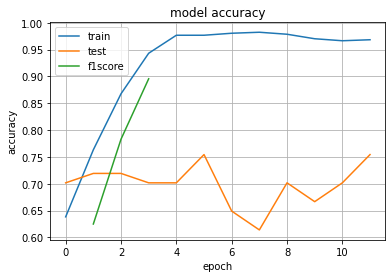

In [17]:
p = np.array(model.predict(train_axial))
train_Men_pred.append(p)
p = np.array(model.predict(test_axial))
test_Men_pred.append(p)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'f1score'], loc='upper left')
plt.grid() 
plt.show()

##### Helper function to clear Memory Utilization enabling it to Work in Colab with K80 GPU and standard RAM allowance.

In [18]:
import gc
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()
    print("...Finished clean up...")

In [19]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/modelResNet501.h5'
model.save(filename)
print('>Saved %s' % filename)
clean_up(model=model)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/modelResNet501.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Axial Plane Scanes checking for ACL Condition

In [20]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_ACL = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [21]:
x = base_model_ax_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=base_model_ax_ACL.input,outputs=predictions)

In [22]:
for layer in model2.layers[64:]:
   layer.trainable = True
for layer in model2.layers[:64]:
  layer.trainable = False

In [23]:
early_stopping_monitor = EarlyStopping(patience=10)    
model2.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history2=model2.fit(train_axial ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 19s 239ms/step - loss: 0.5242 - accuracy: 0.7847 - f1_score: nan - val_loss: 0.4044 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 10s 181ms/step - loss: 0.3391 - accuracy: 0.8527 - f1_score: nan - val_loss: 0.3969 - val_accuracy: 0.8596 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 10s 186ms/step - loss: 0.2266 - accuracy: 0.9180 - f1_score: nan - val_loss: 0.4409 - val_accuracy: 0.8596 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 10s 183ms/step - loss: 0.1446 - accuracy: 0.9525 - f1_score: 0.8601 - val_loss: 0.4975 - val_accuracy: 0.8596 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 10s 180ms/step - loss: 0.0800 - accuracy: 0.9795 - f1_score: nan - val_loss: 0.5785 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 10s 178ms/step - loss: 0.0424 - accuracy: 0.9925 - f1_sc

4/4 [==============================] - 1s 122ms/step - loss: 0.9278 - accuracy: 0.7667 - f1_score: 0.4231
Train loss: 0.9277635216712952
Train accuracy: 0.7666666507720947


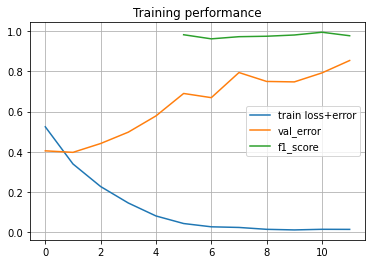

In [24]:
p = np.array(model2.predict(train_axial))
train_ACL_pred.append(p)
p = np.array(model2.predict(test_axial))
test_ACL_pred.append(p)                        
score2 = model2.evaluate(test_axial ,testACL_labels,verbose=1)       
print('Train loss:',score2[0])
print('Train accuracy:',score2[1])                                                                 
plt.figure()
plt.grid()                                                                                                        
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')
plt.plot(history2.epoch, history2.history['f1_score'], label='f1_score')
plt.legend()

In [25]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/modelResNet502.h5'
model2.save(filename)
print('>Saved %s' % filename)
clean_up(model=model2)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/modelResNet502.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Axial Plane Scanes checking for Abnormal Condition

In [26]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_AB = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [27]:
x = base_model_ax_AB.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs=base_model_ax_AB.input,outputs=predictions)

In [28]:
for layer in model3.layers[64:]:
   layer.trainable = True
for layer in model3.layers[:64]:
  layer.trainable = False

In [29]:
early_stopping_monitor = EarlyStopping(patience=10)    
model3.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history3=model3.fit(train_axial ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 15s 195ms/step - loss: 0.6496 - accuracy: 0.6580 - f1_score: nan - val_loss: 0.6871 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 10s 180ms/step - loss: 0.4405 - accuracy: 0.7884 - f1_score: 0.6548 - val_loss: 0.5495 - val_accuracy: 0.7018 - val_f1_score: 0.5943
Epoch 3/100
54/54 [==============================] - 10s 184ms/step - loss: 0.3017 - accuracy: 0.8807 - f1_score: 0.8235 - val_loss: 0.6692 - val_accuracy: 0.7018 - val_f1_score: 0.5839
Epoch 4/100
54/54 [==============================] - 10s 182ms/step - loss: 0.1774 - accuracy: 0.9432 - f1_score: 0.9123 - val_loss: 0.9186 - val_accuracy: 0.6842 - val_f1_score: 0.4127
Epoch 5/100
54/54 [==============================] - 10s 179ms/step - loss: 0.0788 - accuracy: 0.9870 - f1_score: 0.9810 - val_loss: 0.9481 - val_accuracy: 0.7018 - val_f1_score: 0.5353
Epoch 6/100
54/54 [==============================] - 10s 178ms/step - loss: 0.0396 - acc

4/4 [==============================] - 1s 120ms/step - loss: 1.8132 - accuracy: 0.5333 - f1_score: 0.5515
Test loss: 1.8131581544876099
Test accuracy: 0.5333333611488342


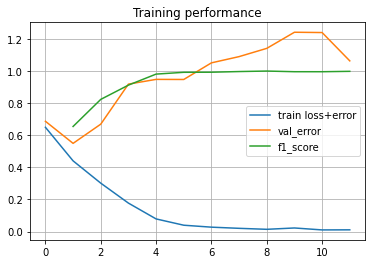

In [30]:
p = np.array(model3.predict(train_axial))
train_Ab_pred.append(p)
p = np.array(model3.predict(test_axial))
test_Ab_pred.append(p)                    
score3 = model3.evaluate(test_axial ,testAb_labels,verbose=1)       
print('Test loss:',score3[0])
print('Test accuracy:',score3[1])                                                              
plt.figure()
plt.grid()                                                                                                
plt.title('Training performance')                          
plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')  
plt.plot(history3.epoch, history3.history['val_loss'], label='val_error') 
plt.plot(history3.epoch, history3.history['f1_score'], label='f1_score') 
plt.legend()

In [31]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model3.h5'
model3.save(filename)
print('>Saved %s' % filename)
clean_up(model=model3)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model3.h5
...Finished clean up...


##### Deleting Files which wont be required further to reduce memory load

In [32]:
del train_axial
del test_axial
del axial_dir
del axial_reloaded
del axialTest_reloaded
del axial_list
del axialTest_list
del model
del model2
del model3
del base_model_ax_men
del base_model_ax_ACL
del base_model_ax_AB
del p


##Coronal Plane Scans

###Reading train & test data

In [33]:
coronal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   
c=sorted(coronal_dir)
coronal_list=np.array(c)
coronal_reloaded=[]
print(coronal_list.shape)
for j in range(1,1131):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/coronal/"+coronal_list[j]
    coronal_reloaded.append(np.load(file2,allow_pickle='false'))

coronal_reloaded=np.array(coronal_reloaded)
print(coronal_reloaded.shape)
train_coronal=[]
 
for j in range(len(coronal_reloaded)):
    mid2=math.floor((coronal_reloaded[j].shape[0])/2)
    train_coronal.append([])
        
    for n in range(mid2-1,mid2+2):
         train_coronal[j].append(coronal_reloaded[j][n])

train_coronal=np.array(train_coronal)
train_coronal=np.reshape(train_coronal,(1130,256,256,3))
print(train_coronal.shape)

coronal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   
c=sorted(coronal_dir)
coronalTest_list=np.array(c)
coronalTest_reloaded=[]
print(coronalTest_list.shape)
for j in range(0,120):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/coronal/"+coronalTest_list[j]
    coronalTest_reloaded.append(np.load(file2,allow_pickle='false'))

coronalTest_reloaded=np.array(coronalTest_reloaded)
print(coronalTest_reloaded.shape)
test_coronal=[]
 
for j in range(len(coronalTest_reloaded)):
    mid2=math.floor((coronalTest_reloaded[j].shape[0])/2)
    test_coronal.append([])
        
    for n in range(mid2-1,mid2+2):
         test_coronal[j].append(coronalTest_reloaded[j][n])

test_coronal=np.array(test_coronal)
test_coronal=np.reshape(test_coronal,(120,256,256,3))
print(test_coronal.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning ResNet50 Model for Coronal Plane Scanes checking for Meniscus Condition

In [34]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_Men = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [35]:
x = base_model_Co_Men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model4 = Model(inputs=base_model_Co_Men.input,outputs=predictions)

In [36]:
for layer in model4.layers[64:]:
   layer.trainable = True
for layer in model4.layers[:64]:
  layer.trainable = False

In [37]:
early_stopping_monitor = EarlyStopping(patience=5)    
model4.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history4=model4.fit(train_coronal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 15s 194ms/step - loss: 0.6471 - accuracy: 0.6477 - f1_score: nan - val_loss: 0.7314 - val_accuracy: 0.5965 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 10s 179ms/step - loss: 0.4731 - accuracy: 0.7856 - f1_score: nan - val_loss: 0.8366 - val_accuracy: 0.5614 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 10s 183ms/step - loss: 0.3370 - accuracy: 0.8630 - f1_score: 0.7841 - val_loss: 0.7421 - val_accuracy: 0.5965 - val_f1_score: 0.2526
Epoch 4/100
54/54 [==============================] - 10s 186ms/step - loss: 0.1652 - accuracy: 0.9562 - f1_score: 0.9338 - val_loss: 0.7813 - val_accuracy: 0.7544 - val_f1_score: 0.6171
Epoch 5/100
54/54 [==============================] - 10s 181ms/step - loss: 0.0766 - accuracy: 0.9916 - f1_score: 0.9888 - val_loss: 1.0500 - val_accuracy: 0.6491 - val_f1_score: 0.3677
Epoch 6/100
54/54 [==============================] - 10s 178ms/step - loss: 0.0536

4/4 [==============================] - 0s 117ms/step - loss: 1.0819 - accuracy: 0.6667 - f1_score: 0.4075
Test loss: 1.0819015502929688
Test accuracy: 0.6666666865348816


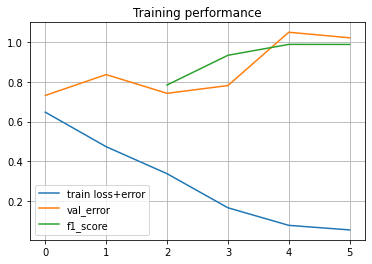

In [38]:
p = np.array(model4.predict(train_coronal))
train_Men_pred.append(p)
p = np.array(model4.predict(test_coronal))
test_Men_pred.append(p)
score4 = model4.evaluate(test_coronal ,testMen_labels,verbose=1)       
print('Test loss:',score4[0])
print('Test accuracy:',score4[1])                                                              
plt.figure()
plt.grid()                                                                                                     
plt.title('Training performance')                          
plt.plot(history4.epoch, history4.history['loss'], label='train loss+error')  
plt.plot(history4.epoch, history4.history['val_loss'], label='val_error')  
plt.plot(history4.epoch, history4.history['f1_score'], label='f1_score')  
plt.legend()

In [39]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model4.h5'
model4.save(filename)
print('>Saved %s' % filename)
clean_up(model=model4)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model4.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Coronal Plane Scanes checking for ACL Condition

In [40]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_ACL = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [41]:
x = base_model_Co_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model5 = Model(inputs=base_model_Co_ACL.input,outputs=predictions)

In [42]:
for layer in model5.layers[64:]:
   layer.trainable = True
for layer in model5.layers[:64]:
  layer.trainable = False

In [43]:
early_stopping_monitor = EarlyStopping(patience=10)    
model5.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history5=model5.fit(train_coronal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 15s 194ms/step - loss: 0.5159 - accuracy: 0.7922 - f1_score: nan - val_loss: 0.4932 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 10s 178ms/step - loss: 0.3682 - accuracy: 0.8388 - f1_score: nan - val_loss: 0.4667 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 10s 181ms/step - loss: 0.2564 - accuracy: 0.8891 - f1_score: nan - val_loss: 0.4544 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 10s 186ms/step - loss: 0.1423 - accuracy: 0.9599 - f1_score: nan - val_loss: 0.6016 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 10s 183ms/step - loss: 0.0755 - accuracy: 0.9823 - f1_score: 0.9016 - val_loss: 0.5872 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 10s 180ms/step - loss: 0.0371 - accuracy: 0.9963 - f1_sc

4/4 [==============================] - 1s 123ms/step - loss: 1.4139 - accuracy: 0.5917 - f1_score: 0.2639
Test loss: 1.4138596057891846
Test accuracy: 0.5916666388511658


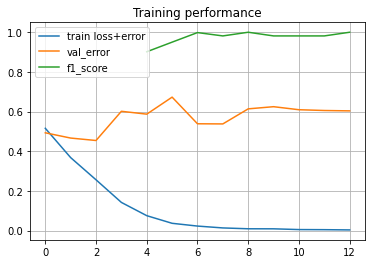

In [44]:
p = np.array(model5.predict(train_coronal))
train_ACL_pred.append(p)
p = np.array(model5.predict(test_coronal, verbose=1))
test_ACL_pred.append(p)              
score5 = model5.evaluate(test_coronal ,testACL_labels,verbose=1)       
print('Test loss:',score5[0])
print('Test accuracy:',score5[1])                                                              
plt.figure()
plt.grid()                                                                                                     
plt.title('Training performance')                          
plt.plot(history5.epoch, history5.history['loss'], label='train loss+error')  
plt.plot(history5.epoch, history5.history['val_loss'], label='val_error') 
plt.plot(history5.epoch, history5.history['f1_score'], label='f1_score') 
plt.legend()

In [45]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model5.h5'
model5.save(filename)
print('>Saved %s' % filename)
clean_up(model=model5)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model5.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Coronal Plane Scanes checking for Abnormal Condition

In [46]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_Ab = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [47]:
x = base_model_Co_Ab.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=base_model_Co_Ab.input,outputs=predictions)

In [48]:
for layer in model6.layers[64:]:
   layer.trainable = True
for layer in model6.layers[:64]:
  layer.trainable = False

In [49]:
early_stopping_monitor = EarlyStopping(patience=10)    
model6.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history6=model6.fit(train_coronal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 15s 196ms/step - loss: 0.6787 - accuracy: 0.6151 - f1_score: nan - val_loss: 0.6986 - val_accuracy: 0.5965 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 10s 180ms/step - loss: 0.4743 - accuracy: 0.7651 - f1_score: nan - val_loss: 0.6262 - val_accuracy: 0.6140 - val_f1_score: 0.3328
Epoch 3/100
54/54 [==============================] - 10s 184ms/step - loss: 0.3179 - accuracy: 0.8733 - f1_score: 0.8035 - val_loss: 0.5843 - val_accuracy: 0.7018 - val_f1_score: 0.6380
Epoch 4/100
54/54 [==============================] - 10s 182ms/step - loss: 0.1539 - accuracy: 0.9618 - f1_score: 0.9420 - val_loss: 0.7070 - val_accuracy: 0.7018 - val_f1_score: 0.5152
Epoch 5/100
54/54 [==============================] - 10s 179ms/step - loss: 0.0763 - accuracy: 0.9897 - f1_score: 0.9868 - val_loss: 0.6809 - val_accuracy: 0.7193 - val_f1_score: 0.5972
Epoch 6/100
54/54 [==============================] - 10s 178ms/step - loss: 0.0385 - accura

4/4 [==============================] - 0s 116ms/step - loss: 2.3051 - accuracy: 0.4500 - f1_score: 0.4524
Test loss: 2.3051116466522217
Test accuracy: 0.44999998807907104


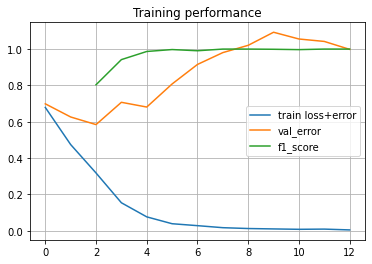

In [50]:
p = np.array(model6.predict(train_coronal))
train_Ab_pred.append(p)
p = np.array(model6.predict(test_coronal))
test_Ab_pred.append(p)        
score6 = model6.evaluate(test_coronal ,testAb_labels,verbose=1)       
print('Test loss:',score6[0])
print('Test accuracy:',score6[1])                                                 
plt.figure()
plt.grid()                                                                                           
plt.title('Training performance')                          
plt.plot(history6.epoch, history6.history['loss'], label='train loss+error')  
plt.plot(history6.epoch, history6.history['val_loss'], label='val_error')   
plt.plot(history6.epoch, history6.history['f1_score'], label='f1_score')   
plt.legend()

In [51]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model6.h5'
model6.save(filename)
print('>Saved %s' % filename)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model6.h5


In [52]:
clean_up(model=model6)

...Finished clean up...


In [53]:
del train_coronal
del test_coronal
del coronal_dir
del coronal_reloaded
del coronalTest_reloaded
del coronal_list
del coronalTest_list
del model4
del model5
del model6
del base_model_Co_Men
del base_model_Co_ACL
del base_model_Co_Ab
del p


##Sagittal Planes Scans

###Reading train & test data

In [55]:
sagittal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   
c=sorted(sagittal_dir)
sagittal_list=np.array(c)
sagittal_reloaded=[]
print(sagittal_list.shape)
for j in range(1,1131):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/sagittal/"+sagittal_list[j]
    sagittal_reloaded.append(np.load(file2,allow_pickle='false'))

sagittal_reloaded=np.array(sagittal_reloaded)
print(sagittal_reloaded.shape)
train_sagittal=[]
 
for j in range(len(sagittal_reloaded)):
    mid2=math.floor((sagittal_reloaded[j].shape[0])/2)
    train_sagittal.append([])  
    for n in range(mid2-1,mid2+2):
         train_sagittal[j].append(sagittal_reloaded[j][n])

train_sagittal=np.array(train_sagittal)
train_sagittal=np.reshape(train_sagittal,(1130,256,256,3))
print(train_sagittal.shape)

sagittal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   
c=sorted(sagittal_dir)
sagittalTest_list=np.array(c)
sagittalTest_reloaded=[]
print(sagittalTest_list.shape)
for j in range(0,120):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/sagittal/"+sagittalTest_list[j]
    sagittalTest_reloaded.append(np.load(file2,allow_pickle='false'))

sagittalTest_reloaded=np.array(sagittalTest_reloaded)
print(sagittalTest_reloaded.shape)
test_sagittal=[]
 
for j in range(len(sagittalTest_reloaded)):
    mid2=math.floor((sagittalTest_reloaded[j].shape[0])/2)
    test_sagittal.append([])  
    for n in range(mid2-1,mid2+2):
         test_sagittal[j].append(sagittalTest_reloaded[j][n])

test_sagittal=np.array(test_sagittal)
test_sagittal=np.reshape(test_sagittal,(120,256,256,3))
print(test_sagittal.shape)



(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Also reading axial scans for future use

In [ ]:
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]

print(axial_list.shape)
for j in range(1,1131):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   
axial_reloaded=np.array(axial_reloaded)

print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])
train_axial=[]

print(len(axial_reloaded))
for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])    
    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)


axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]

print(axialTest_list.shape)

for j in range(0,120):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   
axialTest_reloaded=np.array(axialTest_reloaded)

print(axialTest_reloaded.shape)

s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])
test_axial=[]

print(len(axialTest_reloaded))
for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    
    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

#### Finetuning ResNet50 Model for Sagittal Plane Scanes checking for Mensical Condition

In [56]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_Men = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [57]:
x = base_model_Sa_Men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=base_model_Sa_Men.input,outputs=predictions)

In [58]:
for layer in model7.layers[64:]:
   layer.trainable = True
for layer in model7.layers[:64]:
   layer.trainable = True

In [60]:
trainMen_labels = np.array(trainMen_labels)

In [61]:
early_stopping_monitor = EarlyStopping(patience=10)    
model7.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history7=model7.fit(train_sagittal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 22s 289ms/step - loss: 0.6947 - accuracy: 0.6104 - f1_score: nan - val_loss: 0.7295 - val_accuracy: 0.5965 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 15s 273ms/step - loss: 0.4833 - accuracy: 0.7763 - f1_score: 0.6121 - val_loss: 1.0583 - val_accuracy: 0.5965 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 15s 274ms/step - loss: 0.3054 - accuracy: 0.8947 - f1_score: 0.8458 - val_loss: 1.0770 - val_accuracy: 0.6316 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 14s 267ms/step - loss: 0.1509 - accuracy: 0.9590 - f1_score: 0.9377 - val_loss: 1.3372 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 14s 264ms/step - loss: 0.0618 - accuracy: 0.9916 - f1_score: 0.9902 - val_loss: 1.1461 - val_accuracy: 0.6667 - val_f1_score: 0.4496
Epoch 6/100
54/54 [==============================] - 14s 266ms/step - loss: 0.0397 - 

4/4 [==============================] - 0s 116ms/step - loss: 1.2888 - accuracy: 0.6250 - f1_score: 0.4281
Test loss: 1.2887866497039795
Test accuracy: 0.625


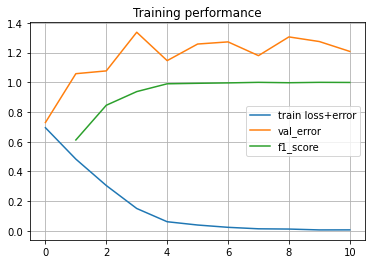

In [62]:
p = np.array(model7.predict(train_sagittal))
train_Men_pred.append(p)
p = np.array(model7.predict(test_sagittal))
test_Men_pred.append(p)             
score7 = model7.evaluate(test_sagittal ,testMen_labels,verbose=1)       
print('Test loss:',score7[0])
print('Test accuracy:',score7[1])                                                            
plt.figure()
plt.grid()                                                                                                    
plt.title('Training performance')                          
plt.plot(history7.epoch, history7.history['loss'], label='train loss+error')  
plt.plot(history7.epoch, history7.history['val_loss'], label='val_error')
plt.plot(history7.epoch, history7.history['f1_score'], label='f1_score')
plt.legend()

In [63]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model7.h5'
model7.save(filename)
print('>Saved %s' % filename)
clean_up(model=model7)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model7.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Sagittal Plane Scanes checking for ACL Condition

In [64]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_ACL = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [65]:
x = base_model_Sa_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model8 = Model(inputs=base_model_Sa_ACL.input,outputs=predictions)

In [66]:
for layer in model8.layers[64:]:
   layer.trainable = True
for layer in model8.layers[:64]:
   layer.trainable = True

In [67]:
early_stopping_monitor = EarlyStopping(patience=5)
model8.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history8=model8.fit(train_sagittal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 20s 286ms/step - loss: 0.4885 - accuracy: 0.7922 - f1_score: nan - val_loss: 0.5273 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 15s 274ms/step - loss: 0.3192 - accuracy: 0.8649 - f1_score: nan - val_loss: 0.6641 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 15s 272ms/step - loss: 0.1764 - accuracy: 0.9329 - f1_score: nan - val_loss: 0.5953 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 14s 267ms/step - loss: 0.0882 - accuracy: 0.9702 - f1_score: 0.8530 - val_loss: 0.5782 - val_accuracy: 0.8772 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 14s 265ms/step - loss: 0.0422 - accuracy: 0.9907 - f1_score: 0.9354 - val_loss: 0.5507 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 14s 265ms/step - loss: 0.0223 - accuracy: 0.9981 - f1

4/4 [==============================] - 0s 119ms/step - loss: 0.8455 - accuracy: 0.7750 - f1_score: 0.5250
Test loss: 0.845480740070343
Test accuracy: 0.7749999761581421


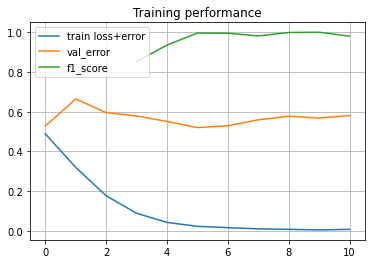

In [68]:
p = np.array(model8.predict(train_sagittal))
train_ACL_pred.append(p)
p = np.array(model8.predict(test_sagittal))
test_ACL_pred.append(p)                  
score8 = model8.evaluate(test_sagittal ,testACL_labels,verbose=1)       
print('Test loss:',score8[0])
print('Test accuracy:',score8[1])                                                               
plt.figure()
plt.grid()                                                                                                        
plt.title('Training performance')                          
plt.plot(history8.epoch, history8.history['loss'], label='train loss+error')  
plt.plot(history8.epoch, history8.history['val_loss'], label='val_error')
plt.plot(history8.epoch, history8.history['f1_score'], label='f1_score')
plt.legend()

In [69]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model8.h5'
model8.save(filename)
print('>Saved %s' % filename)
clean_up(model=model8)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model8.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Sagittal Plane Scanes checking for Abnormal Condition

In [70]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_Ab = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [71]:
x = base_model_Sa_Ab.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model9 = Model(inputs=base_model_Sa_Ab.input,outputs=predictions)

In [72]:
for layer in model9.layers[64:]:
   layer.trainable = True
for layer in model9.layers[:64]:
   layer.trainable = True

In [73]:
early_stopping_monitor = EarlyStopping(patience=10)    
model9.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history9=model9.fit(train_sagittal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 20s 284ms/step - loss: 0.6749 - accuracy: 0.6337 - f1_score: nan - val_loss: 1.0117 - val_accuracy: 0.3860 - val_f1_score: 0.5285
Epoch 2/100
54/54 [==============================] - 15s 274ms/step - loss: 0.4741 - accuracy: 0.7596 - f1_score: nan - val_loss: 0.7312 - val_accuracy: 0.5263 - val_f1_score: 0.4416
Epoch 3/100
54/54 [==============================] - 15s 272ms/step - loss: 0.2974 - accuracy: 0.8788 - f1_score: 0.8158 - val_loss: 0.7665 - val_accuracy: 0.6140 - val_f1_score: 0.4583
Epoch 4/100
54/54 [==============================] - 14s 268ms/step - loss: 0.1538 - accuracy: 0.9627 - f1_score: 0.9396 - val_loss: 1.0727 - val_accuracy: 0.6842 - val_f1_score: 0.4361
Epoch 5/100
54/54 [==============================] - 14s 265ms/step - loss: 0.0743 - accuracy: 0.9870 - f1_score: 0.9655 - val_loss: 1.1767 - val_accuracy: 0.6842 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 14s 265ms/step - loss: 0.0323 - accura

4/4 [==============================] - 0s 118ms/step - loss: 1.7692 - accuracy: 0.5250 - f1_score: 0.5485
Test loss: 1.7691760063171387
Test accuracy: 0.5249999761581421


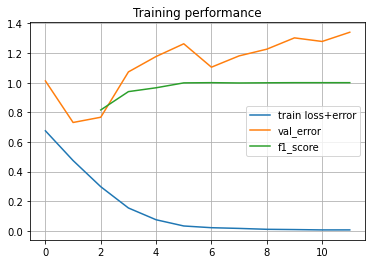

In [74]:
p = np.array(model9.predict(train_sagittal))
train_Ab_pred.append(p)
p = np.array(model9.predict(test_sagittal))
test_Ab_pred.append(p)                  
score9 = model9.evaluate(test_sagittal ,testAb_labels,verbose=1)       
print('Test loss:',score9[0])
print('Test accuracy:',score9[1])                                                             
plt.figure()
plt.grid()                                                                                                    
plt.title('Training performance')                          
plt.plot(history9.epoch, history9.history['loss'], label='train loss+error')  
plt.plot(history9.epoch, history9.history['val_loss'], label='val_error')
plt.plot(history9.epoch, history9.history['f1_score'], label='f1_score')
plt.legend()

In [75]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model9.h5'
model9.save(filename)
print('>Saved %s' % filename)
clean_up(model=model9)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/ResNet50model9.h5
...Finished clean up...


In [77]:
del train_sagittal
del test_sagittal
del sagittal_dir
del sagittal_reloaded
del sagittalTest_reloaded
del sagittal_list
del sagittalTest_list
del model7
del model8
del model9
del base_model_Sa_Men
del base_model_Sa_ACL
del base_model_Sa_Ab
del p

##Ensembling

---
We ensemble the models for each state detection for three planes Axial,Coronal and Sagittal respectively and train a Sequential model with input being probabitity of condition detection by indiviual model and output again being probability person has the condition. We give original label for evaluation of the method.

Although this method couldn't be much accurate that indivual model.
We will look into this and possibly update it with a better variation of the ensembled model.

#### Meniscal Condition Detection

In [78]:
train_Men_pred = np.array(train_Men_pred)
print(train_Men_pred.shape)
test_Men_pred = np.array(test_Men_pred)
print(test_Men_pred.shape)
train_Men_pred = train_Men_pred.reshape((1130,3))
test_Men_pred = test_Men_pred.reshape((120,3))
print(train_Men_pred)

(3, 1130, 1)
(3, 120, 1)
[[2.2139652e-01 7.1467173e-01 1.5975998e-03]
 [9.9168724e-01 3.0735844e-08 9.9934107e-01]
 [1.0025665e-04 1.1673744e-06 1.1605037e-03]
 ...
 [5.8049595e-01 9.5075625e-01 5.7251289e-02]
 [1.3817739e-04 1.6803329e-01 1.3125629e-06]
 [3.8302004e-01 2.2762527e-03 1.7829521e-01]]


In [79]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))
menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score])
h = menModel.fit(train_Men_pred, trainMen_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
36/36 [==============================] - 1s 4ms/step - loss: 0.6935 - acc: 0.5823 - f1_score: nan
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.6879 - acc: 0.5876 - f1_score: nan
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6833 - acc: 0.5903 - f1_score: nan
Epoch 4/50
36/36 [==============================] - 0s 5ms/step - loss: 0.6792 - acc: 0.5912 - f1_score: nan
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6756 - acc: 0.5920 - f1_score: nan
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6728 - acc: 0.5947 - f1_score: nan
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6704 - acc: 0.5938 - f1_score: nan
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6683 - acc: 0.6062 - f1_score: nan
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6667 - acc: 0.6186 - f1_score: nan
Epoch 10/50
36/36 [

4/4 [==============================] - 0s 4ms/step - loss: 0.7063 - acc: 0.5667 - f1_score: nan   
Loss:  0.7062864899635315
Accuracy:  0.5666666626930237


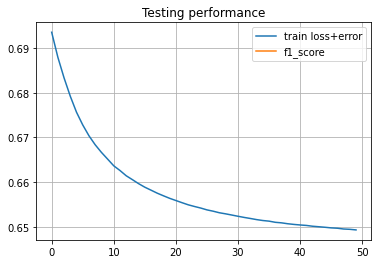

In [80]:
loss, acc, f1 = menModel.evaluate(test_Men_pred, testMen_labels)
p1 = menModel.predict(test_Men_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                                          
plt.figure()
plt.grid()                                                                                                       
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [81]:
del train_Men_pred
del menModel

#### ACL Condition Detection

In [82]:
train_ACL_pred = np.array(train_ACL_pred)
print(train_ACL_pred.shape)
test_ACL_pred = np.array(test_ACL_pred)
print(test_Men_pred.shape)
train_ACL_pred = train_ACL_pred.reshape((1130,3))
test_ACL_pred = test_ACL_pred.reshape((120,3))
print(test_ACL_pred)

(3, 1130, 1)
(120, 3)
[[2.99484418e-05 2.36325559e-05 1.29926607e-01]
 [8.60109460e-04 3.21298698e-03 1.50963198e-03]
 [3.50358486e-01 5.30184984e-01 1.72301934e-05]
 [6.62916631e-04 2.38761492e-03 1.01889716e-02]
 [1.13851288e-02 9.48466768e-05 1.05553016e-01]
 [5.52977917e-06 2.22939067e-03 2.17481283e-03]
 [5.49175456e-05 7.83225914e-06 3.87646636e-04]
 [5.54696044e-06 7.58303868e-05 3.99984219e-06]
 [1.38788237e-04 1.84602992e-04 1.12945156e-03]
 [3.98232660e-04 1.91203959e-03 2.68714433e-03]
 [5.07870107e-04 2.31641684e-06 9.34158504e-01]
 [2.31995285e-02 2.67913219e-05 3.66212311e-03]
 [3.50241479e-03 7.83799961e-03 2.23884284e-02]
 [1.71039045e-01 1.66981034e-02 1.82140302e-02]
 [1.36103258e-01 1.15614189e-02 8.24461162e-01]
 [7.04278564e-03 8.18363726e-01 8.10543001e-01]
 [1.36182387e-03 9.99173939e-01 4.64431429e-03]
 [9.76774991e-01 1.42198727e-02 2.61041820e-01]
 [1.65829789e-02 9.67460692e-01 9.92032051e-01]
 [4.64213872e-03 9.91243243e-01 1.77621469e-01]
 [9.99534488e-01 9

In [83]:
train_ACL_pred

array([[7.35809153e-04, 9.99931693e-01, 2.45317788e-04],
       [1.15348981e-03, 1.01713886e-04, 6.93682116e-04],
       [1.30522496e-03, 1.86323101e-04, 6.67590532e-04],
       ...,
       [4.60837521e-02, 8.42721581e-01, 6.42178522e-04],
       [1.61225814e-03, 7.33357668e-03, 9.85736115e-05],
       [5.64831607e-02, 5.93412342e-03, 8.98557842e-01]], dtype=float32)

In [84]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))
menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_score])
h = menModel.fit(train_ACL_pred, trainACL_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
36/36 [==============================] - 1s 3ms/step - loss: 0.7993 - accuracy: 0.6150 - f1_score: nan
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7787 - accuracy: 0.6301 - f1_score: nan
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7594 - accuracy: 0.6310 - f1_score: nan
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7412 - accuracy: 0.6389 - f1_score: nan
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7239 - accuracy: 0.6407 - f1_score: nan
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.6504 - f1_score: nan
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.6531 - f1_score: nan
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.6540 - f1_score: nan
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6641 - accurac

4/4 [==============================] - 0s 4ms/step - loss: 0.8169 - accuracy: 0.5500 - f1_score: nan   
Loss:  0.8168710470199585
Accuracy:  0.550000011920929


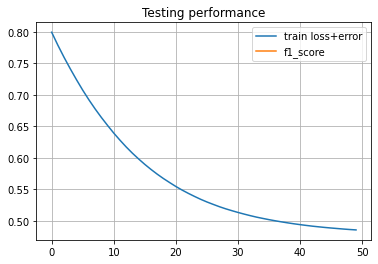

In [85]:
loss, acc, f1 = menModel.evaluate(test_ACL_pred, testACL_labels)
p2 = menModel.predict(test_ACL_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                
plt.figure()
plt.grid()                                                                                                   
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [86]:
del train_ACL_pred
del menModel

####Abnormal Condition Detection

In [87]:
np.isnan(np.sum(trainAb_labels))

False

In [88]:
train_Ab_pred = np.array(train_Ab_pred)
print(train_Ab_pred.shape)
test_Ab_pred = np.array(test_Ab_pred)
print(test_Ab_pred.shape)
train_Ab_pred = train_Ab_pred.reshape((1130,3))
test_Ab_pred = test_Ab_pred.reshape((120,3))
print(test_ACL_pred)

(3, 1130, 1)
(3, 120, 1)
[[2.99484418e-05 2.36325559e-05 1.29926607e-01]
 [8.60109460e-04 3.21298698e-03 1.50963198e-03]
 [3.50358486e-01 5.30184984e-01 1.72301934e-05]
 [6.62916631e-04 2.38761492e-03 1.01889716e-02]
 [1.13851288e-02 9.48466768e-05 1.05553016e-01]
 [5.52977917e-06 2.22939067e-03 2.17481283e-03]
 [5.49175456e-05 7.83225914e-06 3.87646636e-04]
 [5.54696044e-06 7.58303868e-05 3.99984219e-06]
 [1.38788237e-04 1.84602992e-04 1.12945156e-03]
 [3.98232660e-04 1.91203959e-03 2.68714433e-03]
 [5.07870107e-04 2.31641684e-06 9.34158504e-01]
 [2.31995285e-02 2.67913219e-05 3.66212311e-03]
 [3.50241479e-03 7.83799961e-03 2.23884284e-02]
 [1.71039045e-01 1.66981034e-02 1.82140302e-02]
 [1.36103258e-01 1.15614189e-02 8.24461162e-01]
 [7.04278564e-03 8.18363726e-01 8.10543001e-01]
 [1.36182387e-03 9.99173939e-01 4.64431429e-03]
 [9.76774991e-01 1.42198727e-02 2.61041820e-01]
 [1.65829789e-02 9.67460692e-01 9.92032051e-01]
 [4.64213872e-03 9.91243243e-01 1.77621469e-01]
 [9.99534488e-0

In [89]:
abModel = Sequential()
abModel.add(Dense(1, activation='sigmoid', input_dim=3))
abModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score] )
h = abModel.fit(train_Ab_pred, trainAb_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
36/36 [==============================] - 1s 3ms/step - loss: 0.7411 - acc: 0.5549 - f1_score: 0.3632
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7289 - acc: 0.5540 - f1_score: nan
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7184 - acc: 0.5540 - f1_score: 0.3547
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7092 - acc: 0.5540 - f1_score: nan
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.7017 - acc: 0.5549 - f1_score: nan
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6950 - acc: 0.5558 - f1_score: 0.3515
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6894 - acc: 0.5602 - f1_score: nan
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6846 - acc: 0.5628 - f1_score: 0.3463
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6805 - acc: 0.5637 - f1_score: 0.3497
Epoc

4/4 [==============================] - 0s 5ms/step - loss: 0.9135 - acc: 0.2083 - f1_score: nan
Loss:  0.9134663939476013
Accuracy:  0.2083333283662796


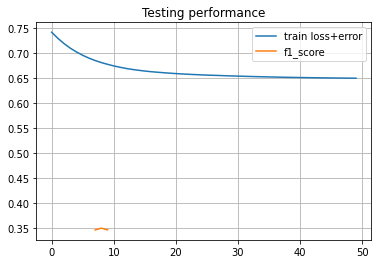

In [90]:
loss, acc, f1 = abModel.evaluate(test_Ab_pred, testAb_labels)
p3 = abModel.predict(test_Ab_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                     
plt.figure()
plt.grid()                                                                                                     
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [91]:
del train_Ab_pred
del abModel